In [1]:
from PIL import Image
import numpy as np
import math
import cv2
import glob
from scipy import ndimage
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
import scipy.misc
from skimage import exposure
import os 

In [10]:
'''ok! but it's better to read all the slices of different frams at once 
and converting the "*.tif" files into grayscale and finally converting
them into numpy array'''

directory_list = list()
for root, dirs, files in os.walk('/home/vel/Downloads/dat_files/' , topdown=False):
    for name in dirs:
        if not (name.startswith('.')):
            directory_list.append(os.path.join(root, name))

sorted_path = sorted(directory_list)

all_images = list ()
extension = '*.tif'
for i in range(len(sorted_path)):
    all_images.append([cv2.imread(file,cv2.IMREAD_GRAYSCALE) for file in sorted(glob.glob(os.path.join(sorted_path[i],extension)))]) 
print(len(all_images))

63


In [11]:
#Now let's see the dimensions of our giant numpy array
all_ims = np.asarray(all_images)
np.shape(all_ims)

(63, 41, 500, 502)

Let's start our real work from now on !

### Step 1: Thresholding all the frames :


### Parallelization of Step 1


In [12]:
total = np.asarray(all_images)
print(np.shape(all_images))

BW = np.array([i if i > 42 else 0 for i in range(0,256)]).astype(np.uint8)


(63, 41, 500, 502)


In [13]:
total.shape[1]

41

In [14]:
from multiprocessing import Pool
import time 
global total
global BW
th = []
def thresholding(i):
    ret = []
    for x in range(total.shape[1]):
        ret.append(cv2.LUT(total[i][x], BW))
    return ret

In [15]:
%%time
p = Pool()
th.append(p.map(thresholding,  range(63)))
p.close()
p.join()

CPU times: user 160 ms, sys: 906 ms, total: 1.07 s
Wall time: 1.39 s


In [16]:
res = np.asarray(th[0])
res.shape

(63, 41, 500, 502)

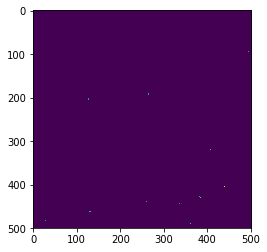

In [54]:
plt.imshow(res[60][8])
plt.show()

In [17]:
# I mentioned the non parallel part here , only to check the performance with the parallel one.

%%time
'''
First we extract the labels of the componets for all the cells
across all the frames. Thus the number of components and their labels
are discovered here:
'''
from scipy.ndimage.measurements import label
structure = np.ones((3,3,3), dtype = np.int)


all_labeled = np.zeros(shape=(63, 41, 500, 502))
all_ncomponents = np.zeros(res.shape[0])
for frames in range (res.shape[0]): 
    all_labeled[frames], all_ncomponents[frames] = label(res[frames], structure)


CPU times: user 5.38 s, sys: 1.66 s, total: 7.04 s
Wall time: 7.01 s


In [18]:
all_ncomponents

array([ 256.,  256.,  289.,  292.,  282.,  267.,  254.,  247.,  249.,
        203.,  191.,  225.,  209.,  217.,  218.,  207.,  230.,  189.,
        191.,  192.,  203.,  207.,  163.,  152.,  149.,  153.,  158.,
        143.,  155.,  160.,  152.,  155.,  157.,  154.,  147.,  149.,
        138.,  144.,  146.,  146.,  142.,  155.,  144.,  171.,  178.,
        168.,  169.,  170.,  171.,  153.,  166.,  148.,  159.,  161.,
        161.,  157.,  163.,  160.,  168.,  160.,  164.,  157.,  158.])

### Step 2 Parallelization : 3d CCL 

In [21]:
from joblib import Parallel, delayed
import multiprocessing

In [22]:
num_cores = multiprocessing.cpu_count()
num_cores

36

In [24]:
%%time
o1 = Parallel(n_jobs=num_cores)(delayed(label)(res[frames],structure) for frames in range(res.shape[0]))

CPU times: user 2.05 s, sys: 3.51 s, total: 5.56 s
Wall time: 5.97 s


In [25]:
all_labeled_par = np.zeros(shape=(63, 41, 500, 502))
all_ncomponents_par = np.zeros(res.shape[0])
for i in range(res.shape[0]):
    all_labeled_par[i]=o1[i][0]
    all_ncomponents_par[i]=o1[i][1]

In [27]:
all_ncomponents_par

array([ 256.,  256.,  289.,  292.,  282.,  267.,  254.,  247.,  249.,
        203.,  191.,  225.,  209.,  217.,  218.,  207.,  230.,  189.,
        191.,  192.,  203.,  207.,  163.,  152.,  149.,  153.,  158.,
        143.,  155.,  160.,  152.,  155.,  157.,  154.,  147.,  149.,
        138.,  144.,  146.,  146.,  142.,  155.,  144.,  171.,  178.,
        168.,  169.,  170.,  171.,  153.,  166.,  148.,  159.,  161.,
        161.,  157.,  163.,  160.,  168.,  160.,  164.,  157.,  158.])

### Step 3 : Centroids detection parallely 

In [29]:
from scipy.ndimage.measurements import center_of_mass


In [45]:
%%time
'''
Now let's extract all the centers across all the frames.
comment: I changed my previous way that was very slow, thus the the 
computation time reduced from 7 hours to only 5 mins !
'''

all_centers2 = []
for frames in range (res.shape[0]):
    #print(frames)
    all_centers2.append(center_of_mass(res[frames], 
                        labels=all_labeled[frames], 
                        index=range(1, int(all_ncomponents[frames]))))

CPU times: user 1min 33s, sys: 39.8 s, total: 2min 12s
Wall time: 2min 12s


In [42]:
%%time
all_Centers_par = Parallel(n_jobs=num_cores)(delayed(center_of_mass)(res[frames],all_labeled_par[frames], range(1, int(all_ncomponents_par[frames])))for frames in range(res.shape[0]))

CPU times: user 3.96 s, sys: 5.55 s, total: 9.5 s
Wall time: 18.3 s


In [41]:
len(all_centers_par)


246

### Now let us do the parallelization on denoising :
    First we need to compute the volume for each component and then computing the centroids only for 
    the components with volume greater than a thrshold (Let's say 1 pixel here)

In [48]:
unique = list()
counts = list()
for frames in range(res.shape[0]):
    unique.append(np.unique(all_labeled_par[frames], return_counts = True)[0])
    counts.append(np.unique(all_labeled_par[frames], return_counts = True)[1])
#components_volume[frames] = dict(zip(unique, counts))
unique[0]

array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,
        108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,
        117.,  118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,
        126.,  127.,

In [49]:
%%time
# Serial part of filtering the noise (Just for comparison with the parallel version)
# Here I'm selecting only the center of the components with the volume 
# less than 1 pixel and put them in thr_idxs list  :
thr_idxs = [[]]
for i in range (len(counts)):
    for j in range (len (counts[i])):
        if counts[i][j] > 1 : 
            thr_idxs[i].append(unique[i][j])
    thr_idxs.append([])
thr_idxs = [pick for pick in thr_idxs if len(pick) > 0 ]
print(len(thr_idxs),len(thr_idxs[0]))



63 119
CPU times: user 4.34 ms, sys: 168 µs, total: 4.51 ms
Wall time: 4.37 ms


### Step 4 : denoising part parallelization

In [50]:
def indexthr(frame,unique_array):
    thr_idxs2=[]
    n_labels=len(frame)
    for i in range(n_labels):
        if frame[i] > 1 : 
            thr_idxs2.append(unique_array[i])
    return thr_idxs2 

In [51]:
%%time
thr_idxs4=Parallel(n_jobs=num_cores)(delayed(indexthr)(counts[frame],unique[frame])for frame in range(res.shape[0]))

CPU times: user 95.6 ms, sys: 4.64 s, total: 4.74 s
Wall time: 4.71 s


In [52]:
len(thr_idxs4)

63

In [53]:
%%time
all_centers_noisefree_par = Parallel(n_jobs=num_cores)(delayed(center_of_mass)(res[frames],all_labeled_par[frames], thr_idxs4[frames])for frames in range(res.shape[0]))

CPU times: user 3.7 s, sys: 5.21 s, total: 8.91 s
Wall time: 18.4 s


In [55]:
len(all_centers_noisefree_par)

63

## Now let's visualize and check the parallel results: 

In [57]:
all_cnf = np.asarray(all_centers_noisefree_par)

znf3d = [[]]
xnf3d = [[]]
ynf3d = [[]]

for frames in range(all_cnf.shape[0]):
    for i in range (np.shape(all_cnf[frames])[0]):
        znf3d[frames].append(all_cnf[frames][i][0])
        xnf3d[frames].append(all_cnf[frames][i][1])
        ynf3d[frames].append(all_cnf[frames][i][2])
    znf3d.append([])
    xnf3d.append([])
    ynf3d.append([])

In [58]:
len(ynf3d[0])

119

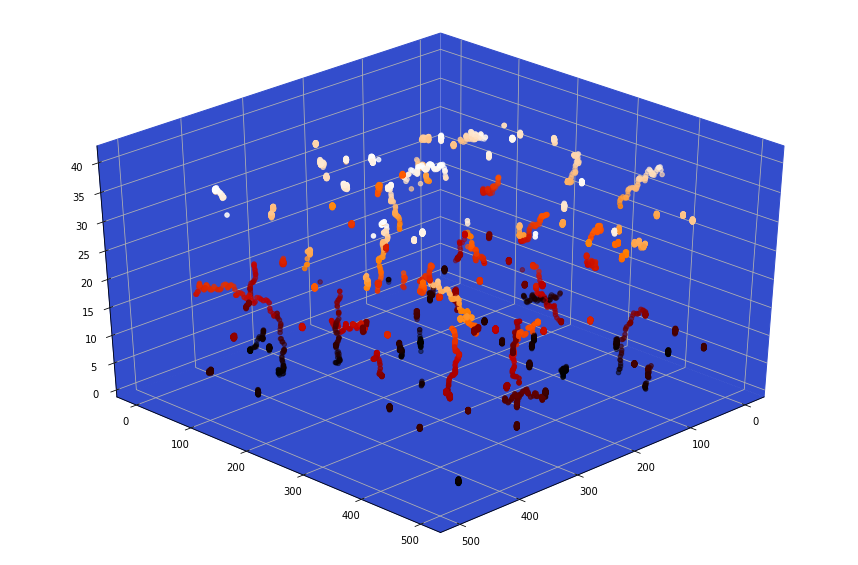

In [60]:


# ok! Now let us visualize the final detection results:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(all_cnf.shape[0]):
    ax.scatter(ynf3d[i], xnf3d[i], znf3d[i], 
               zdir='znf3d[i]', marker = "o",  c= znf3d[i], cmap='gist_heat')

ax.w_xaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.w_yaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.w_zaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.view_init(35, 45)
plt.grid(False)
plt.savefig("demo2center-allnf.png", dpi=600)
plt.show()

# Sounds Great!